In [123]:
import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import pandas as pd
import pathlib as pl

import plotly.express as px
import plotly.graph_objects as go

import numpy as np

from src.metrics import bateman_flower_constancy_index as bateman_idx, mateo_flower_constancy_index as mateo_idx

## Preprocess 
The original csv has strings like ababa-bbaaba-aaaaa  where each bout is separated by "-".
We can analize constancy for each bout, so we must split the series and keep track of the bout number, date and bee id

In [125]:
df = pd.read_csv(pl.Path("/home/mateo/code/beehaviour/data/visit_sequence/constancia_floral_piloto.csv"))
df = df.rename(columns={'.':'date', 'Experimento':'arena', 'Abeja': 'bee', 'Secuencia': 'sequence'})
df.dropna(inplace=True)

# this asumes that every state is present at least once,
# a reasonable hack which might fail in edge cases
df['states'] = df.sequence.apply(lambda x: set(x).difference({'-'}))
df['arena'] = df['arena'].str.strip()

# Experimental defintion
this is one of the points that need the most work in order to future proof it.
Define a proper ontology of experimental paradigms

In [126]:
df.arena.unique()

array(['Color Azul 1.5 M vs Blanco 1.5 M',
       'Color Azul 2.0 M vs Blanco 1.0 M',
       'Color Azul 1.0 M vs Blanco 2.0 M',
       'Forma Guias X 1.5 M vs C 1.5 M', 'Forma Guias X 2.0 M vs C 1.0 M',
       'Numero Guias 8 1.5 M vs 4 1.5 M',
       'Numero Guias 8 2.0 M vs 4 1.0 M',
       'Numero Guias 8 1.0 M vs 4 2.0 M',
       'Forma Cuadrado 1.5 M vs Circulo 1.5 M',
       'Forma Cuadrado 1.0 M vs Circulo 2.0 M',
       'Numero Forma 8 1.5 M vs 4 1.5 M',
       'Numero Forma 8 2.0 M vs 4 1.0 M',
       'Forma Circulo 1.5 M vs Estrella 1.5 M',
       'Forma Circulo 2.0 M vs Estrella 1.0 M',
       'Forma Circulo 2.0 M vs Estrella 0.0 M',
       'Tamaño Pequeña 1.5 M vs Grande 1.5 M',
       'Tamaño Pequeña 2.0 M vs Grande 1.0 M',
       'Tamaño Pequeña 1.0 M vs Grande 2.0 M',
       'Forma Circulo 1.0 M vs Estrella 2.0 M',
       'Concentracion Alta 2.0 M vs Baja 1.5 M'], dtype=object)

# Infers experiment stage
Reads arena name bee id and date/order, identifies concentration changes,
then asigns 'baseline' 'learning' or 'relearning' to a new column

In [127]:
# extract dimension ("variable"), and dimension levels, alongside associated reward concentrations.
df[["variable", "level_0", "reward_0", "level_1", "reward_1"]] = df.arena.str.extract(r"\A(\D+) (\S+) (\d\.\d) M vs (\S+) (\d\.\d) M\Z")
df['experiment'] = [str(x) + '_' + '_'.join(sorted([str(y),str(z)])) for x, y, z in zip(df['variable'], df['level_0'], df['level_1'])]

df.experiment.unique()


array(['Color_Azul_Blanco', 'Forma Guias_C_X', 'Numero Guias_4_8',
       'Forma_Circulo_Cuadrado', 'Numero Forma_4_8',
       'Forma_Circulo_Estrella', 'Tamaño_Grande_Pequeña',
       'Concentracion_Alta_Baja'], dtype=object)

In [128]:
df

,date,arena,bee,sequence,states,variable,level_0,reward_0,level_1,reward_1,experiment
0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,ababababa-aabbabbbabaab-ababbabababaa-baababaa...,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco
1,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,aup001,abaaba-abbabaab-aaabbbabbaababa-bbaababababab-...,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco
2,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,vap001,babbbbababab-abababaabb-abababab-babaaba-babab...,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco
3,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,vup001,aaaaaabaa-aaaababbaaabab-abaabbabababaa-aababa...,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco
5,2024-06-27,Color Azul 2.0 M vs Blanco 1.0 M,adp001,ababaaba-abaabaababababaa-abbaaabaababaaa-abba...,"{a, b}",Color,Azul,2.0,Blanco,1.0,Color_Azul_Blanco
...,...,...,...,...,...,...,...,...,...,...,...
72,2024-10-15,Forma Circulo 2.0 M vs Estrella 1.0 M,bup002,CECCCECE-CECCECCEECE-EECECECE-EECECEECECEE-CEC...,"{C, E}",Forma,Circulo,2.0,Estrella,1.0,Forma_Circulo_Estrella
73,2024-10-17,Forma Circulo 2.0 M vs Estrella 1.0 M,bup001,CCECECEC-CCCECEEC-CCEECECCECCEEC-ECCECCCC-ECEC...,"{C, E}",Forma,Circulo,2.0,Estrella,1.0,Forma_Circulo_Estrella
74,2024-10-17,Forma Circulo 2.0 M vs Estrella 1.0 M,bup002,CCEEEECC-CCCEEECEECEC-EECECCECEEE-CECEECECEC-C...,"{C, E}",Forma,Circulo,2.0,Estrella,1.0,Forma_Circulo_Estrella
75,2024-10-18,Forma Circulo 1.0 M vs Estrella 2.0 M,bup001,EEEECE-ECEECEEE-EEECECEECE-EEEEEE-EECEEECEE-EE...,"{E, C}",Forma,Circulo,1.0,Estrella,2.0,Forma_Circulo_Estrella


In [129]:
def set_stages(indf):
    """
    Set experiment stages: first a baseline, when the reward concentration is equal for the different flowers
    Then a first learning stage, when the concentrations are different.
    Finally,if there are ultirior changes to concentrations, set those stages of the experiment as relearning

    This is a helper function intended to be used within groubby.apply.
    Args:
        indf: DF generated by groupby.

    Returns:
        same inpud DF with an adde column specifying the stage of the experiment.

    """
    learning_flag = True
    prev_row = None
    stages = list()
    for rr, (_, row) in enumerate(indf.iterrows()):
        
        # checks if this row has the same experimental definition as the prior, and 
        # sets an equal stage name if so.
        if prev_row is not None:
            if (
                    prev_row.reward_0 == row.reward_0 and 
                    prev_row.reward_1 == row.reward_1 and
                    prev_row.experiment == row.experiment
            ):
                stages.append(prev_stage)
                prev_row = row
                continue
            
        if row.reward_0 == row.reward_1:
            this_stage = "baseline"
        else:
            if learning_flag:
                this_stage = "learning"
                learning_flag = False
            else:
                this_stage = "relearning"
                if rr >= 3:
                    # warnings.warn(
                    print(
                        f"bee '{indf.bee[0]}' on experiment '{indf.experiment[0]}' has"
                        f"multiple relearning stages, ambiguously set as 'relearning'"
                    )
        stages.append(this_stage)
        prev_row = row
        prev_stage = this_stage
        
        
    indf['stage'] = stages
    return indf

df = df.groupby(['bee', 'experiment']).apply(set_stages)

# long tidy format
Splits sequences of bouts (separated by "-") into individual bouts, one per row.

In [130]:
# make the table into a long tidy formag
df['sequence'] = df['sequence'].str.split("-")
df = df.explode('sequence')
# df.index.rename("experiment", inplace=True)
df.reset_index(inplace=True)
df['bout'] = df.groupby(['bee', 'arena']).cumcount()
df['bee_bout'] = df.groupby(['bee']).cumcount()
df.head()


,index,date,arena,bee,sequence,states,variable,level_0,reward_0,level_1,reward_1,experiment,stage,bout,bee_bout
0,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,ababababa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,0,0
1,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,aabbabbbabaab,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,1,1
2,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,ababbabababaa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,2,2
3,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,baababaabababaaaaa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,3,3
4,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,aababababbaab,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,4,4


# Bateman index fails with outliers
here is the proof with a simple toy example where the bateman index, by vitue of having a 0 on the transition diagonal
collapses to -1, total alternancy, when in realitiy is mostly constant.

My variation on the index is correctly close to 1, total constancy. 

In [131]:
# this simple toy example shows the numerical instability of the bateman index

print(bateman_idx(
    pd.Series([i for i in "abaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"]),
    print_trans_mat=True
))
print(mateo_idx(
    pd.Series([i for i in "abaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"]),
    print_trans_mat=True
))


[[0.96875 0.03125]
 [1.      0.     ]]
-1.0
[[31.  1.]
 [ 1.  0.]]
0.9393939393939394


In [132]:
# calculate multiple indices for constancy (bateman and mateo), and preference

for rn, row in df.iterrows():
    # df.loc[rn, 'bateman_fci'] = bateman_idx(
    #     pd.Series([i for i in row.sequence]),
    #     states=list(row.states),
    #     print_trans_mat=False
    # )
    
    
    df.loc[rn, 'mateo_fci'] = mateo_idx(
        pd.Series([i for i in row.sequence]),
        states=list(row.states),
        print_trans_mat=False
    )
    
    # Preference index 
    _, counts = np.unique(
        [i for i in row.sequence],
        return_counts=True
        )
    
    df.loc[rn, 'preference'] = counts[0] / counts.sum()
    # df.loc[rn, 'preference'] = counts.max() / counts.sum()

# transforms a [0, 1] into a [-1, 1] index 
df['mateo_fci'] = df['mateo_fci'] * 2 - 1      

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/variable.py:652: RuntimeWarning:

coroutine 'InteractiveShell.run_cell_async' was never awaited



In [133]:
# fig = px.scatter(data_frame=df, x='bateman_fci', y='mateo_fci')
# fig.add_trace(go.Scatter(x=[-1,1], y=[-1,1], mode="lines", 
#                          line=dict(color='black',
#                                    dash='dot'),
#                                    showlegend=False))
# 
# fig.update_layout(template='simple_white')
# fig.show(renderer='jpeg')
# fig.write_image(pl.Path(f"../results/figures/fci_comparison.jpeg"))

# Plot
Quick display of the constancy over time for different artificial flower patch experiments.

In [134]:
df.head()

,index,date,arena,bee,sequence,states,variable,level_0,reward_0,level_1,reward_1,experiment,stage,bout,bee_bout,mateo_fci,preference
0,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,ababababa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,0,0,-1.000000,0.555556
1,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,aabbabbbabaab,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,1,1,-0.166667,0.461538
2,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,ababbabababaa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,2,2,-0.666667,0.538462
3,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,baababaabababaaaaa,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,3,3,-0.294118,0.666667
4,0,2024-06-26,Color Azul 1.5 M vs Blanco 1.5 M,adp001,aababababbaab,"{a, b}",Color,Azul,1.5,Blanco,1.5,Color_Azul_Blanco,baseline,4,4,-0.500000,0.538462


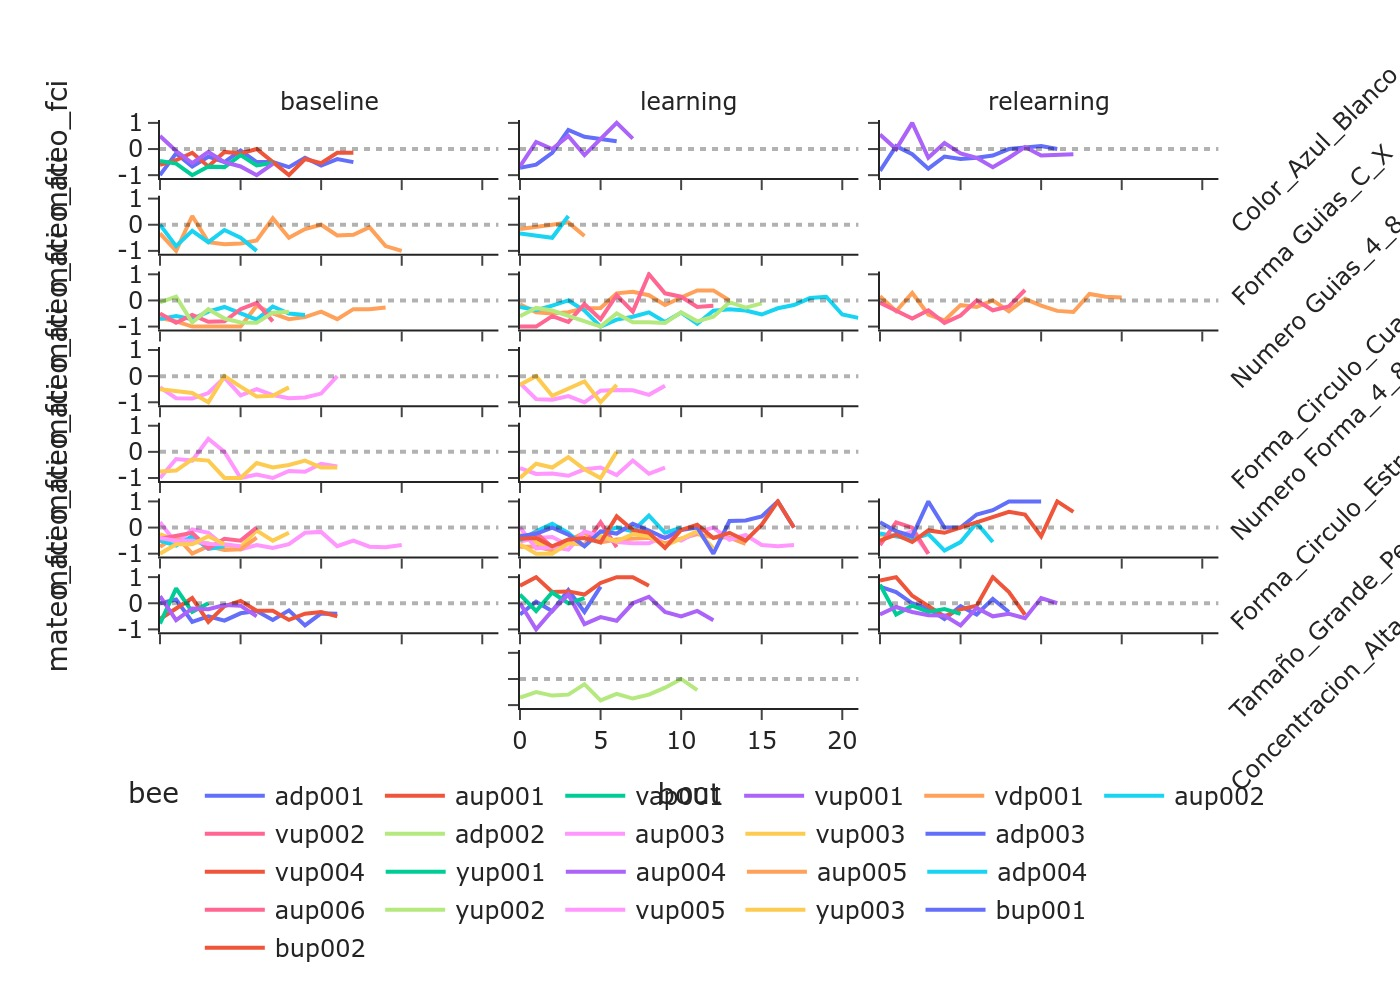

In [135]:
fig = px.line(data_frame=df, x='bout' , y='mateo_fci', color='bee',
              facet_col='stage', facet_row='experiment')

fig.add_hline(y=0, row='all', col='all')
fig.for_each_shape(lambda s: s.update(line=dict(color='black', dash='dot', width=2)))

# fig.add_traces(go.Scatter(x=[0,20], y=[0,0], mode='lines', line=dict(color='gray', dash='dot')), rows='all')

fig.update_layout(
    template='simple_white',
    legend=dict(
        orientation = "h",
        xanchor = "center",
        x = 0.5
    )
)

fig.update_yaxes(
    tickmode = 'array',
    tickvals = [-1, 0, 1],
    ticktext = [-1, 0, 1]
)


#remove the prefix on facet annotations
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# rotate row annotations for clarity
fig.for_each_annotation(
    lambda a: a.update(textangle=-45),
    # selector=lambda a: '_' in a.text
    selector=lambda a: a.text not in ["baseline", "learning", "relearning"]
)

fig.show(renderer='jpeg', scale=2)
# fig.write_image(pl.Path("../results/figures/santiago_floral_constancy_time_series.svg"))

# average constancy and preference
We are taking the average of the last 3 bouts for constancy and preference 

In [136]:
def last3avg(ser):
    return np.round(ser.tail(3).mean(),3)

meandf = df.sort_values('date', ascending=True).groupby(
    ['experiment', 'stage', 'bee']
).agg(arena=('arena', 'first'), date=('date', 'first'), mean_preference=('preference', last3avg), mean_fci=('mateo_fci', last3avg))

df.experiment.unique()

array(['Color_Azul_Blanco', 'Forma Guias_C_X', 'Numero Guias_4_8',
       'Forma_Circulo_Cuadrado', 'Numero Forma_4_8',
       'Forma_Circulo_Estrella', 'Tamaño_Grande_Pequeña',
       'Concentracion_Alta_Baja'], dtype=object)

In [137]:
expt_name = 'Forma_Circulo_Estrella'

meandf.loc[(expt_name, ('baseline', 'learning', 'relearning'),('bup001', 'bup002')),:]

arena  \
experiment             stage      bee                                             
Forma_Circulo_Estrella learning   bup001  Forma Circulo 2.0 M vs Estrella 1.0 M   
                                  bup002  Forma Circulo 2.0 M vs Estrella 1.0 M   
                       relearning bup001  Forma Circulo 1.0 M vs Estrella 2.0 M   
                                  bup002  Forma Circulo 1.0 M vs Estrella 2.0 M   

                                                date  mean_preference  \
experiment             stage      bee                                   
Forma_Circulo_Estrella learning   bup001  2024-10-15            0.750   
                                  bup002  2024-10-15            0.600   
                       relearning bup001  2024-10-18            0.472   
                                  bup002  2024-10-18            0.565   

                                          mean_fci  
experiment             stage      bee               
Forma_Circulo_Estrella learning   bup001     0.048  
                                  bup002     0.513  
                       relearning bup001     0.352  
                                  bup002     0.367

# plots by experiment

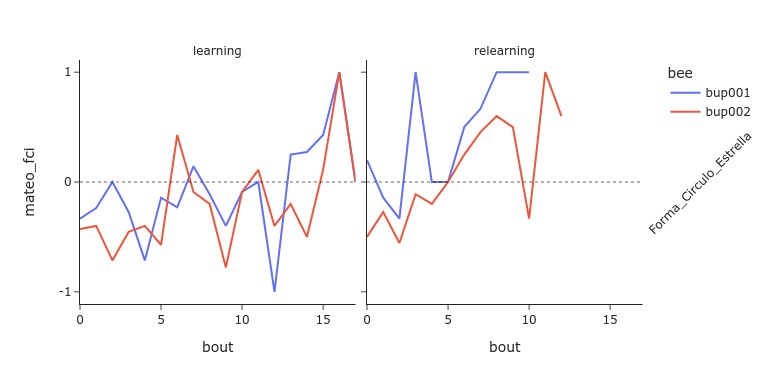

In [140]:
fig = px.line(data_frame=df.query(f"experiment == '{expt_name}' and "
                                  f"bee in ['bup001', 'bup002']"),
              x='bout' , 
              y='mateo_fci',
              # y='preference',
              color='bee',
              facet_col='stage', facet_row='experiment')

fig.add_hline(y=0, row='all', col='all')
fig.for_each_shape(lambda s: s.update(line=dict(color='black', dash='dot', width=2)))

# fig.add_traces(go.Scatter(x=[0,20], y=[0,0], mode='lines', line=dict(color='gray', dash='dot')), rows='all')

fig.update_layout(
    template='simple_white',
    width=96*8, height=96*4,
)

fig.update_yaxes(
    tickmode = 'array',
    tickvals = [-1, 0, 1],
    ticktext = [-1, 0, 1]
)

# fig.update_yaxes(
#     tickmode = 'array',
#     tickvals = [0, 0.5, 1],
#     ticktext = [0, 0.5, 1]
# )


#remove the prefix on facet annotations
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

# rotate row annotations for clarity
fig.for_each_annotation(
    lambda a: a.update(textangle=-45),
    selector=lambda a: '_' in a.text
)

fig.show(renderer='jpeg')
# fig.show()
# fig.write_image(pl.Path(f"../results/figures/constancy_{expt_name}.jpeg"))